In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pricing_benchmark import calculate_perp_priceV4 
from itertools import product

In [78]:
num_days = 1
new_pos_per_day = 100

minimal_spread = 0.0001 # param
incentive_spread = 0.0001 # param
log_ret_sigma = 0.08 # param > real typical vol
trade_size_mu = 10 # gains equivalent
trade_size_scale = 3 
s_20 = 1_800

In [79]:
trade_size_buckets = [[1,10], [10, 30], [30, 60], [60, 100], [100, 200], [200, 400], [400, 600], [600, 800], [800, 1_000]]
M_amounts = [200_000, 300_000, 1_000_000]

In [80]:
log_ret_mus = [0, -0.005, 0.005]
prob_longs = [0.4, 0.5, 0.6]
num_iter = 200

In [81]:
def generate_state(log_ret_mu, log_ret_sigma, trade_size_mu, trade_size_scale, prob_long, num_days):
    # price path (daily increments), use 50% of "implied vol" (calibrated vol)
    s_2 = np.exp(np.cumsum(np.random.normal(log_ret_mu - 0.5 * (log_ret_sigma * 0.5)**2, log_ret_sigma * 0.5, num_days)))[:,np.newaxis] * s_20
    # trades
    trade_sizes = np.random.gamma(trade_size_mu / trade_size_scale, trade_size_scale, (num_days, new_pos_per_day))
    trade_dirs = np.where(np.random.uniform(size=(num_days, new_pos_per_day)) < prob_long, 1,-1)
    trade_amounts = trade_sizes * trade_dirs
    aggregated_trade_amounts = np.sum(trade_amounts, axis=-1)
    # aggregate
    L1 = np.sum(s_2 * aggregated_trade_amounts)
    K2 = np.sum(trade_amounts)
    
    volume = np.sum(trade_sizes * s_2)
    res = (K2, L1, s_2[-1,0], np.mean(trade_sizes), volume)
    # print(res)
    return res

In [82]:
grid = product(log_ret_mus, prob_longs, range(num_iter))
states = [generate_state(log_ret_mu, log_ret_sigma, trade_size_mu, trade_size_scale, prob_long, num_days) for log_ret_mu, prob_long, _ in grid]
print(np.mean(np.array(states), axis=0))
print(np.std(np.array(states), axis=0))

[-4.22881406e+00 -7.86621333e+03  1.79788388e+03  1.00009250e+01
  1.79797010e+06]
[1.98574199e+02 3.56654670e+05 7.13582699e+01 5.57620082e-01
 1.22057276e+05]


In [83]:
def get_slippage(k, M):
    grid = product(log_ret_mus, prob_longs, range(num_iter))
    states = [generate_state(log_ret_mu, log_ret_sigma, trade_size_mu, trade_size_scale, prob_long, num_days) for log_ret_mu, prob_long, _ in grid]
    prices = [calculate_perp_priceV4(K2, k, L1, s2, 1, log_ret_sigma, 1, 0, 0, M, 0, 0, minSpread=minimal_spread, incentiveSpread=incentive_spread, k_bar=pos_size_ema)
                 for K2, L1, s2, pos_size_ema, vol in states]
    slippages = [calculate_perp_priceV4(K2, k, L1, s2, 1, log_ret_sigma, 1, 0, 0, M, 0, 0, minSpread=minimal_spread, incentiveSpread=incentive_spread, k_bar=pos_size_ema) / s2 - 1
                 for K2, L1, s2, pos_size_ema, vol in states]
    volumes = [state[-1] for state in states]
    print(states[0], states[1], states[3])
    return np.array(slippages), np.array(volumes), np.array(prices)

In [87]:
slippages, volumes, prices = get_slippage(100, M_amounts[1])
prices

(-277.3572442451644, -483357.56340373744, 1742.7255766086398, 9.978661774397102, 1739006.9094568782) (-291.9669618805456, -515484.86893715407, 1765.5589030243011, 10.02550786175723, 1770062.4662665601) (-247.42768124986688, -447538.5530424204, 1808.7650936293985, 9.984985263050907, 1806049.2804210442)


array([1743.07412172, 1765.9120148 , 1771.09735242, ..., 1790.39067338,
       1767.08478363, 1896.23824066])

array([2.        , 2.        , 2.        , 2.        , 2.00000089,
       2.00987973])

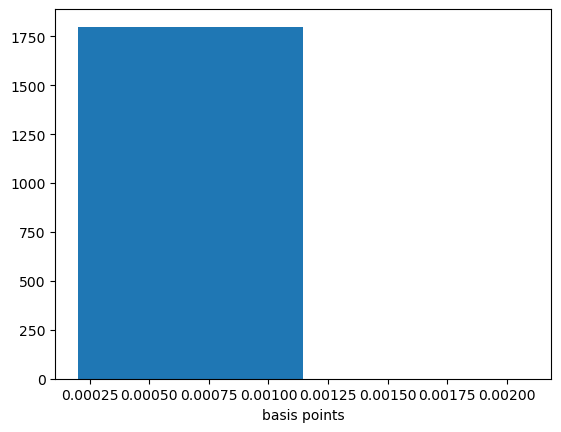

In [92]:
plt.hist(np.abs(slippages), 2)
plt.xlabel('basis points')
np.quantile(np.abs(slippages), [0.1, 0.25, 0.5, 0.6, 0.75, 0.9]) * 1e4


Text(0.5, 0, 'mmUSD')

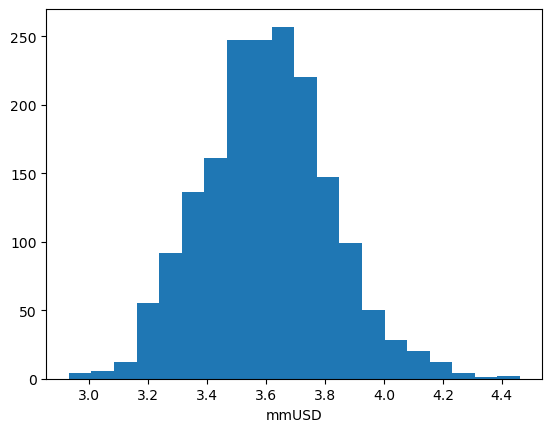

In [57]:
plt.hist(volumes / 1e6, 20)
plt.xlabel('mmUSD')

In [35]:
slippages

array([0.0002, 0.0002, 0.0002, ..., 0.0002, 0.0002, 0.0002])